# Harmonize annotations for the RBC-GEM

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    ANNOTATION_PATH,
    MODEL_PATH,
    INTERIM_PATH,
    read_rbc_model,
    compare_tables,
    visualize_comparison,
    split_string,
    explode_column,
)

from rbc_gem_utils.database import (
    HUMANGEM_DB_TAG,
    UNIPROT_DB_TAG,
    MIM_DB_TAG,
    TCDB_DB_TAG,
    DRUGBANK_DB_TAG,
    DRUGCENTRAL_DB_TAG,
    CDCDB_DB_TAG,
    COMPLEXPORTAL_DB_TAG,
)
from cobra.io.sbml import validate_sbml_model

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
model = read_rbc_model(filetype="xml")
model.reactions.sort()
model.genes.sort()
model.metabolites.sort()
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,RBC_GEM
Memory address,1501be6d0
Number of metabolites,2057
Number of reactions,3030
Number of genes,779
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Create annotation tables

In [4]:
annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
compare = True
display_nunique = True
overwrite = True
compare_figsize = None

preserve_model_previous = True
model_annotation_dfs = {
    "reactions": None,
    "metabolites": None,
    "genes": None,
}
to_double_check = {
    "reactions": {},
    "metabolites": {},
    "genes": {},
}

### Reactions

In [5]:
annotation_type = "reactions"
databases = [HUMANGEM_DB_TAG, "References"]
df_annotations_all = pd.read_csv(
    f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
    sep="\t",
)

df_annotations_all = df_annotations_all.set_index(annotation_type)
df_annotations_all = df_annotations_all.rename(
    {c: f"{c}_MODEL" for c in df_annotations_all.columns}, axis=1
)

for db_tag in databases:
    df = pd.read_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
    ).set_index(annotation_type)
    df.columns = [f"{c}_{db_tag}" for c in df.columns]
    df_annotations_all = df_annotations_all.merge(
        df,
        left_index=True,
        right_index=True,
        how="outer",
    )

# Keep database tags on duplicate columns for reconcilliation, remove for unique columns
unique_columns = set([name.rsplit("_", 1)[0] for name in df_annotations_all.columns])
to_double_check[annotation_type] = {
    unique: [
        name for name in df_annotations_all.columns if name.rsplit("_", 1)[0] == unique
    ]
    for unique in unique_columns
}
unique_mapping = {
    to_double_check[annotation_type].pop(unique).pop(): unique
    for unique, dbs in to_double_check[annotation_type].copy().items()
    if len(dbs) == 1
}
print(f"Annotation columns to reconcile: {to_double_check[annotation_type]}")
df_annotations_all = df_annotations_all.replace(float("nan"), pd.NA).replace("", pd.NA)
df_annotations_all

Annotation columns to reconcile: {'ec-code': ['ec-code_MODEL', 'ec-code_MetAtlas'], 'bigg.reaction': ['bigg.reaction_MODEL', 'bigg.reaction_MetAtlas'], 'tcdb': ['tcdb_MODEL', 'tcdb_MetAtlas'], 'rhea': ['rhea_MODEL', 'rhea_MetAtlas'], 'reactome': ['reactome_MODEL', 'reactome_MetAtlas'], 'metanetx.reaction': ['metanetx.reaction_MODEL', 'metanetx.reaction_MetAtlas'], 'vmhreaction': ['vmhreaction_MODEL', 'vmhreaction_MetAtlas'], 'spontaneous': ['spontaneous_MODEL', 'spontaneous_MetAtlas'], 'kegg.reaction': ['kegg.reaction_MODEL', 'kegg.reaction_MetAtlas'], 'references': ['references_MODEL', 'references_References'], 'metatlas': ['metatlas_MODEL', 'metatlas_MetAtlas']}


,biocyc_MODEL,sabiork.reaction_MODEL,sbo_MODEL,seed.reaction_MODEL,metanetx.reaction_MODEL,kegg.reaction_MODEL,vmhreaction_MODEL,metatlas_MODEL,reactome_MODEL,tcdb_MODEL,...,kegg.reaction_MetAtlas,bigg.reaction_MetAtlas,reactome_MetAtlas,vmhreaction_MetAtlas,metanetx.reaction_MetAtlas,tcdb_MetAtlas,rhea_MetAtlas,spontaneous_MetAtlas,ec-code_MetAtlas,references_References
reactions,,,,,,,,,,,,,,,,,,,,,
13DAMPPOX,<NA>,<NA>,SBO:0000176,<NA>,MNXR94687,<NA>,13DAMPPOX,MAR07992,<NA>,<NA>,...,<NA>,13DAMPPOX,<NA>,13DAMPPOX,MNXR94687,<NA>,<NA>,0.0,1.4.3.6;1.4.3.21;1.4.3.22,pubmed:23330127
15KPGE1Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
15KPGE2Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
15KPGE3Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
15KPGF1Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YYYTPAP,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:6058286;pubmed:7002549
ZN2Htex2,<NA>,<NA>,SBO:0000185,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:11817695;pubmed:18936201;pubmed:2245666...
ZN2_2HCO3t,<NA>,<NA>,SBO:0000185,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:22456662;pubmed:22898811;pubmed:2484233...


#### Reconcile cross-referenced from multiple sources
These columns had multiple mappings and need to be reconciled.

In [6]:
reconcilliation = {
    # Overwrite with MetAtlas
    "metanetx.reaction": HUMANGEM_DB_TAG,
    "kegg.reaction": HUMANGEM_DB_TAG,
    "vmhreaction": HUMANGEM_DB_TAG,
    "metatlas": HUMANGEM_DB_TAG,
    "reactome": HUMANGEM_DB_TAG,
    "tcdb": HUMANGEM_DB_TAG,
    "ec-code": HUMANGEM_DB_TAG,
    "rhea": HUMANGEM_DB_TAG,
    # Preserve from model, some BiGG mappings in MetAtlas are off.
    "bigg.reaction": "MODEL",
    # Non-miriam fields, spontaneous comes from References
    "spontaneous": "MODEL",
    "references": "References",
}

df_annotations = df_annotations_all.copy()
for key, chosen_col in reconcilliation.items():
    if key not in to_double_check[annotation_type]:
        continue
    df_base_column = df_annotations_all.loc[:, f"{key}_{chosen_col}"].copy()
    df_base_column.name = key
    df_columns = df_annotations_all.loc[:, to_double_check[annotation_type][key]]
    for idx, row in df_columns.iterrows():
        if preserve_model_previous:
            # Preserve old ID to prevent loss of ID
            try:
                if not row.isna()[f"{key}_MODEL"] and row.isna()[f"{key}_{chosen_col}"]:
                    df_base_column[idx] = row[f"{key}_MODEL"]
            except KeyError as e:
                pass

    df_annotations = df_annotations.drop(to_double_check[annotation_type][key], axis=1)
    to_double_check[annotation_type].pop(key)
    df_annotations[key] = df_base_column


# Overwrite
df_annotations = df_annotations.rename(unique_mapping, axis=1)
df_annotations = df_annotations.reset_index(drop=False).fillna("")
model_annotation_dfs[annotation_type] = df_annotations
df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
df_annotations

,reactions,biocyc,sabiork.reaction,sbo,seed.reaction,metanetx.reaction,kegg.reaction,vmhreaction,metatlas,reactome,tcdb,ec-code,rhea,bigg.reaction,spontaneous,references
0,13DAMPPOX,<NA>,<NA>,SBO:0000176,<NA>,MNXR94687,<NA>,13DAMPPOX,MAR07992,<NA>,<NA>,1.4.3.6;1.4.3.21;1.4.3.22,<NA>,13DAMPPOX,0.0,pubmed:23330127
1,15KPGE1Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15KPGE1Ry,0.0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
2,15KPGE2Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15KPGE2Ry,0.0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
3,15KPGE3Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15KPGE3Ry,0.0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
4,15KPGF1Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15KPGF1Ry,0.0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029,YYYTPAP,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,YYYTPAP,0.0,pubmed:6058286;pubmed:7002549
3030,ZN2Htex2,<NA>,<NA>,SBO:0000185,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ZN2Htex2,0.0,pubmed:11817695;pubmed:18936201;pubmed:2245666...
3031,ZN2_2HCO3t,<NA>,<NA>,SBO:0000185,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,pubmed:22456662;pubmed:22898811;pubmed:2484233...
3032,ZN2_HCO3_SELNIt,<NA>,<NA>,SBO:0000185,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,pubmed:22456662;pubmed:22898811;pubmed:2716625...


#### Save annotations

reactions: 3034
biocyc: 188
sabiork.reaction: 149
sbo: 3
seed.reaction: 288
metanetx.reaction: 1160
kegg.reaction: 526
vmhreaction: 1590
metatlas: 1559
reactome: 243
tcdb: 31
ec-code: 390
rhea: 511
bigg.reaction: 3495
spontaneous: 2
references: 931


,reactions,biocyc,sabiork.reaction,sbo,seed.reaction,metanetx.reaction,kegg.reaction,vmhreaction,metatlas,reactome,tcdb,ec-code,rhea,bigg.reaction,spontaneous,references
0,13DAMPPOX,<NA>,<NA>,SBO:0000176,<NA>,MNXR94687,<NA>,13DAMPPOX,MAR07992,<NA>,<NA>,1.4.3.6;1.4.3.21;1.4.3.22,<NA>,13DAMPPOX,0.0,pubmed:23330127
1,15KPGE1Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15KPGE1Ry,0.0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
2,15KPGE2Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15KPGE2Ry,0.0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
3,15KPGE3Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15KPGE3Ry,0.0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
4,15KPGF1Ry,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15KPGF1Ry,0.0,pubmed:236730;pubmed:24657656;pubmed:6597453;p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029,YYYTPAP,<NA>,<NA>,SBO:0000176,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,YYYTPAP,0.0,pubmed:6058286;pubmed:7002549
3030,ZN2Htex2,<NA>,<NA>,SBO:0000185,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ZN2Htex2,0.0,pubmed:11817695;pubmed:18936201;pubmed:2245666...
3031,ZN2_2HCO3t,<NA>,<NA>,SBO:0000185,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,pubmed:22456662;pubmed:22898811;pubmed:2484233...
3032,ZN2_HCO3_SELNIt,<NA>,<NA>,SBO:0000185,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,pubmed:22456662;pubmed:22898811;pubmed:2716625...


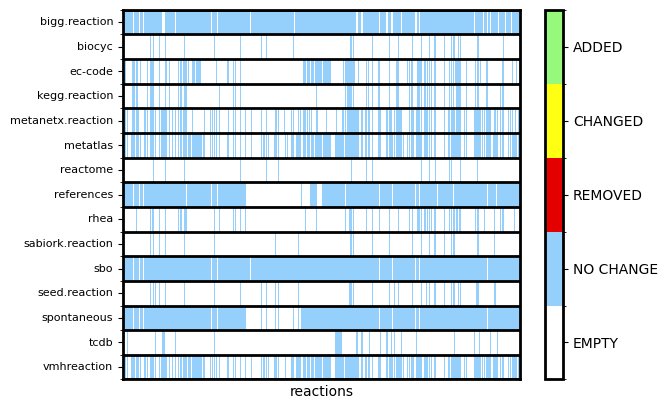

In [7]:
assert (
    len(to_double_check[annotation_type]) == 0
), f"There are still columns with data that need reconcilliation: {to_double_check[annotation_type]}"
df_annotations = model_annotation_dfs[annotation_type]

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations

### Metabolites

In [8]:
annotation_type = "metabolites"
databases = [HUMANGEM_DB_TAG]
df_annotations_all = pd.read_csv(
    f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
    sep="\t",
)

df_annotations_all = df_annotations_all.set_index(annotation_type)
df_annotations_all = df_annotations_all.rename(
    {c: f"{c}_MODEL" for c in df_annotations_all.columns}, axis=1
)

for db_tag in databases:
    df = pd.read_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
    ).set_index(annotation_type)
    df.columns = [f"{c}_{db_tag}" for c in df.columns]
    df_annotations_all = df_annotations_all.merge(
        df,
        left_index=True,
        right_index=True,
        how="outer",
    )

# Keep database tags on duplicate columns for reconcilliation, remove for unique columns
unique_columns = set([name.rsplit("_", 1)[0] for name in df_annotations_all.columns])
to_double_check[annotation_type] = {
    unique: [
        name for name in df_annotations_all.columns if name.rsplit("_", 1)[0] == unique
    ]
    for unique in unique_columns
}
unique_mapping = {
    to_double_check[annotation_type].pop(unique).pop(): unique
    for unique, dbs in to_double_check[annotation_type].copy().items()
    if len(dbs) == 1
}
print(f"Annotation columns to reconcile: {to_double_check[annotation_type]}")
df_annotations_all = df_annotations_all.replace(float("nan"), pd.NA).replace("", pd.NA)
df_annotations_all

Annotation columns to reconcile: {'metatlas': ['metatlas_MODEL', 'metatlas_MetAtlas'], 'bigg.metabolite': ['bigg.metabolite_MODEL', 'bigg.metabolite_MetAtlas'], 'metanetx.chemical': ['metanetx.chemical_MODEL', 'metanetx.chemical_MetAtlas'], 'hmdb': ['hmdb_MODEL', 'hmdb_MetAtlas'], 'vmhmetabolite': ['vmhmetabolite_MODEL', 'vmhmetabolite_MetAtlas'], 'pubchem.compound': ['pubchem.compound_MODEL', 'pubchem.compound_MetAtlas'], 'lipidmaps': ['lipidmaps_MODEL', 'lipidmaps_MetAtlas'], 'kegg.compound': ['kegg.compound_MODEL', 'kegg.compound_MetAtlas'], 'chebi': ['chebi_MODEL', 'chebi_MetAtlas']}


,biocyc_MODEL,envipath_MODEL,inchikey_MODEL,kegg.drug_MODEL,kegg.glycan_MODEL,reactome_MODEL,sabiork.compound_MODEL,sbo_MODEL,seed.compound_MODEL,slm_MODEL,...,bigg.metabolite_MODEL,metatlas_MetAtlas,bigg.metabolite_MetAtlas,kegg.compound_MetAtlas,hmdb_MetAtlas,chebi_MetAtlas,pubchem.compound_MetAtlas,lipidmaps_MetAtlas,vmhmetabolite_MetAtlas,metanetx.chemical_MetAtlas
metabolites,,,,,,,,,,,,,,,,,,,,,
10fthf_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,...,10fthf,MAM00266c,10fthf,C00234,<NA>,CHEBI:15637,122347.0,<NA>,10fthf,MNXM237
12ppd__R_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,...,12ppd__R,MAM02771c,12ppd__R,C00583,HMDB0001881,CHEBI:16997,1030.0,<NA>,12ppd_R,MNXM1118;MNXM1255;MNXM90191
12ppd__S_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,...,12ppd__S,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
13dampp_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,...,13dampp,MAM00248c,13dampp,C00986,HMDB0000002,CHEBI:15725,428.0,<NA>,13dampp,MNXM146468;MNXM350
13dpg_c,META:DPG,<NA>,LJQLQCAXBUHEAZ-UWTATZPHSA-J,<NA>,<NA>,29800,21215,SBO:0000247,cpd00203,<NA>,...,13dpg,MAM00247c,13dpg,C00236,<NA>,CHEBI:16001,439191.0,<NA>,13dpg,MNXM261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zn2_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,...,zn2,MAM03157c,<NA>,C00038,HMDB0015532,CHEBI:29105,32051.0,<NA>,zn2,MNXM149
zn2_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,...,zn2,MAM03157e,<NA>,C00038,HMDB0015532,CHEBI:29105,32051.0,<NA>,zn2,MNXM149
ztp_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,...,ztp,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


#### Reconcile cross-referenced from multiple sources
These columns had multiple mappings and need to be reconciled.

In [9]:
reconcilliation = {
    # Overwrite with MetAtlas
    "kegg.compound": HUMANGEM_DB_TAG,
    "lipidmaps": HUMANGEM_DB_TAG,
    "hmdb": HUMANGEM_DB_TAG,
    "vmhmetabolite": HUMANGEM_DB_TAG,
    "metatlas": HUMANGEM_DB_TAG,
    "chebi": HUMANGEM_DB_TAG,
    "pubchem.compound": HUMANGEM_DB_TAG,
    "metanetx.chemical": HUMANGEM_DB_TAG,
    # Preserve from model, some BiGG mappings in MetAtlas are off.
    "bigg.metabolite": "MODEL",
    # # Non-miriam fields
    "references": "References",
}

df_annotations = df_annotations_all.copy()
for key, chosen_col in reconcilliation.items():
    if key not in to_double_check[annotation_type]:
        continue
    df_base_column = df_annotations_all.loc[:, f"{key}_{chosen_col}"].copy()
    df_base_column.name = key
    df_columns = df_annotations_all.loc[:, to_double_check[annotation_type][key]]
    for idx, row in df_columns.iterrows():
        if preserve_model_previous:
            # Preserve old ID to prevent loss of ID
            try:
                if not row.isna()[f"{key}_MODEL"] and row.isna()[f"{key}_{chosen_col}"]:
                    df_base_column[idx] = row[f"{key}_MODEL"]
            except KeyError as e:
                pass
    df_annotations[key] = df_base_column
    df_annotations = df_annotations.drop(to_double_check[annotation_type][key], axis=1)
    to_double_check[annotation_type].pop(key)


# Overwrite
df_annotations = df_annotations.rename(unique_mapping, axis=1)
df_annotations = df_annotations.reset_index(drop=False).fillna("")
model_annotation_dfs[annotation_type] = df_annotations
df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
df_annotations

,metabolites,biocyc,envipath,inchikey,kegg.drug,kegg.glycan,reactome,sabiork.compound,sbo,seed.compound,slm,kegg.compound,lipidmaps,hmdb,vmhmetabolite,metatlas,chebi,pubchem.compound,metanetx.chemical,bigg.metabolite
0,10fthf_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00234,<NA>,<NA>,10fthf,MAM00266c,CHEBI:15637,122347.0,MNXM237,10fthf
1,12ppd__R_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00583,<NA>,HMDB0001881,12ppd_R,MAM02771c,CHEBI:16997,1030.0,MNXM1118;MNXM1255;MNXM90191,12ppd__R
2,12ppd__S_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,12ppd__S
3,13dampp_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00986,<NA>,HMDB0000002,13dampp,MAM00248c,CHEBI:15725,428.0,MNXM146468;MNXM350,13dampp
4,13dpg_c,META:DPG,<NA>,LJQLQCAXBUHEAZ-UWTATZPHSA-J,<NA>,<NA>,29800,21215,SBO:0000247,cpd00203,<NA>,C00236,<NA>,HMDB62758,13dpg,MAM00247c,CHEBI:16001,439191.0,MNXM261,13dpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,zn2_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00038,<NA>,HMDB0015532,zn2,MAM03157c,CHEBI:29105,32051.0,MNXM149,zn2
2053,zn2_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00038,<NA>,HMDB0015532,zn2,MAM03157e,CHEBI:29105,32051.0,MNXM149,zn2
2054,ztp_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ztp
2055,zymst_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C05437,LMST01010066,<NA>,zymst,MAM03158c,CHEBI:18252,92746.0,MNXM574,zymst


#### Save annotations

metabolites: 2057
biocyc: 212
envipath: 72
inchikey: 184
kegg.drug: 64
kegg.glycan: 6
reactome: 455
sabiork.compound: 218
sbo: 1
seed.compound: 224
slm: 7
kegg.compound: 767
lipidmaps: 227
hmdb: 501
vmhmetabolite: 1144
metatlas: 1450
chebi: 710
pubchem.compound: 676
metanetx.chemical: 1173
bigg.metabolite: 1571


,metabolites,biocyc,envipath,inchikey,kegg.drug,kegg.glycan,reactome,sabiork.compound,sbo,seed.compound,slm,kegg.compound,lipidmaps,hmdb,vmhmetabolite,metatlas,chebi,pubchem.compound,metanetx.chemical,bigg.metabolite
0,10fthf_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00234,<NA>,<NA>,10fthf,MAM00266c,CHEBI:15637,122347.0,MNXM237,10fthf
1,12ppd__R_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00583,<NA>,HMDB0001881,12ppd_R,MAM02771c,CHEBI:16997,1030.0,MNXM1118;MNXM1255;MNXM90191,12ppd__R
2,12ppd__S_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,12ppd__S
3,13dampp_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00986,<NA>,HMDB0000002,13dampp,MAM00248c,CHEBI:15725,428.0,MNXM146468;MNXM350,13dampp
4,13dpg_c,META:DPG,<NA>,LJQLQCAXBUHEAZ-UWTATZPHSA-J,<NA>,<NA>,29800,21215,SBO:0000247,cpd00203,<NA>,C00236,<NA>,HMDB62758,13dpg,MAM00247c,CHEBI:16001,439191.0,MNXM261,13dpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,zn2_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00038,<NA>,HMDB0015532,zn2,MAM03157c,CHEBI:29105,32051.0,MNXM149,zn2
2053,zn2_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C00038,<NA>,HMDB0015532,zn2,MAM03157e,CHEBI:29105,32051.0,MNXM149,zn2
2054,ztp_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ztp
2055,zymst_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,C05437,LMST01010066,<NA>,zymst,MAM03158c,CHEBI:18252,92746.0,MNXM574,zymst


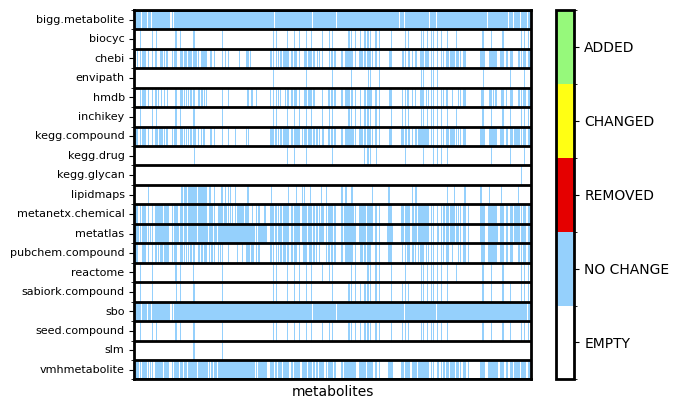

In [10]:
assert (
    len(to_double_check[annotation_type]) == 0
), f"There are still columns with data that need reconcilliation: {to_double_check[annotation_type]}"
df_annotations = model_annotation_dfs[annotation_type]

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t", index=False
    )
df_annotations

### Genes

In [11]:
annotation_type = "genes"
databases = [
    HUMANGEM_DB_TAG,
    UNIPROT_DB_TAG,
    MIM_DB_TAG,
    TCDB_DB_TAG,
    DRUGBANK_DB_TAG,
    DRUGCENTRAL_DB_TAG,
    # CDCDB_DB_TAG,
    COMPLEXPORTAL_DB_TAG,
    "References",
]
df_annotations_all = pd.read_csv(
    f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t", index_col=None
)

df_annotations_all = df_annotations_all.set_index(annotation_type)
df_annotations_all = df_annotations_all.rename(
    {c: f"{c}_MODEL" for c in df_annotations_all.columns}, axis=1
)

for db_tag in databases:
    df = pd.read_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
    ).set_index(annotation_type)
    df.columns = [f"{c}_{db_tag}" for c in df.columns]
    df_annotations_all = df_annotations_all.merge(
        df,
        left_index=True,
        right_index=True,
        how="outer",
    )

# Keep database tags on duplicate columns for reconcilliation, remove for unique columns
unique_columns = set([name.rsplit("_", 1)[0] for name in df_annotations_all.columns])
to_double_check[annotation_type] = {
    unique: [
        name for name in df_annotations_all.columns if name.rsplit("_", 1)[0] == unique
    ]
    for unique in unique_columns
}
unique_mapping = {
    to_double_check[annotation_type].pop(unique).pop(): unique
    for unique, dbs in to_double_check[annotation_type].copy().items()
    if len(dbs) == 1
}
print(f"Annotation columns to reconcile: {to_double_check[annotation_type]}")
df_annotations_all = df_annotations_all.replace(float("nan"), pd.NA).replace("", pd.NA)
df_annotations_all

Annotation columns to reconcile: {'dip': ['dip_MODEL', 'dip_UniProt'], 'merops': ['merops_MODEL', 'merops_UniProt'], 'complexportal': ['complexportal_MODEL', 'complexportal_UniProt', 'complexportal_ComplexPortal'], 'smpdb': ['smpdb_MODEL', 'smpdb_DrugBank'], 'disprot': ['disprot_MODEL', 'disprot_UniProt'], 'efo': ['efo_MODEL', 'efo_ComplexPortal'], 'supfam': ['supfam_MODEL', 'supfam_UniProt'], 'pubmed': ['pubmed_MODEL', 'pubmed_ComplexPortal'], 'pfam': ['pfam_MODEL', 'pfam_UniProt', 'pfam_TCDB', 'pfam_DrugBank'], 'genetree': ['genetree_MODEL', 'genetree_UniProt'], 'orphanet': ['orphanet_MODEL', 'orphanet_UniProt', 'orphanet_ComplexPortal'], 'bmrb': ['bmrb_MODEL', 'bmrb_UniProt'], 'ideal': ['ideal_MODEL', 'ideal_UniProt'], 'ena.embl': ['ena.embl_MODEL', 'ena.embl_UniProt'], 'ensembl': ['ensembl_MODEL', 'ensembl_MetAtlas', 'ensembl_UniProt', 'ensembl_MIM'], 'prints': ['prints_MODEL', 'prints_UniProt'], 'mgi': ['mgi_MODEL', 'mgi_MIM'], 'genewiki': ['genewiki_MODEL', 'genewiki_UniProt'], '

,hprd_MODEL,ncbigi_MODEL,sbo_MODEL,pubchem.compound_MODEL,uniprot_MODEL,uniprot.isoform_MODEL,uniprot.chain_MODEL,refseq_MODEL,ncbigene_MODEL,hgnc.symbol_MODEL,...,pdb_ComplexPortal,intact_ComplexPortal,reactome_ComplexPortal,pubmed_ComplexPortal,efo_ComplexPortal,rhea_ComplexPortal,orphanet_ComplexPortal,mondo_ComplexPortal,mim_ComplexPortal,references_References
genes,,,,,,,,,,,,,,,,,,,,,
A4GALT,<NA>,<NA>,SBO:0000243,<NA>,Q9NPC4,<NA>,PRO_0000080578,NP_001304967.1;NP_059132.1;XP_005261701.1;XP_0...,53947,A4GALT,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:12888565;pubmed:29662110;pubmed:34360826
AARS1,<NA>,<NA>,SBO:0000243,<NA>,P49588,P49588-1;P49588-2,PRO_0000075281,NP_001596.2,16,AARS1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:19421340;pubmed:35976696
AASDHPPT,<NA>,<NA>,SBO:0000243,<NA>,Q9NRN7,Q9NRN7-1;Q9NRN7-2,PRO_0000175736,NP_056238.2,60496,AASDHPPT,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
ABCA1,<NA>,<NA>,SBO:0000243,14985;2733525;2733526;3488;4912;5957,O95477,<NA>,PRO_0000093288,NP_005493.2,19,ABCA1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:27239515;pubmed:32907987
ABCA7,<NA>,<NA>,SBO:0000243,<NA>,Q8IZY2,Q8IZY2-1;Q8IZY2-2,PRO_0000250674,NP_061985.2;XP_011525930.1,10347,ABCA7,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,pubmed:12917409;pubmed:15520449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YES1,<NA>,<NA>,<NA>,<NA>,P07947,<NA>,PRO_0000088181,NP_005424.1;XP_016881449.1,7525,YES1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
ZDHHC2,<NA>,<NA>,SBO:0000243,<NA>,Q9UIJ5,<NA>,PRO_0000212859,NP_057437.1,51201,ZDHHC2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
ZDHHC20,<NA>,<NA>,SBO:0000243,<NA>,Q5W0Z9,Q5W0Z9-1;Q5W0Z9-2;Q5W0Z9-3;Q5W0Z9-4,PRO_0000212906,NP_001273567.1;NP_001316988.1;NP_694983.2,253832,ZDHHC20,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


#### Reconcile cross-referenced from multiple sources
These columns had multiple mappings and need to be reconciled.

Currently, overwrites with one database and will preserve previous model annotations if nothing exists for a field.

In [12]:
reconcilliation = {
    # Overwrite with UniProt
    "uniprot": UNIPROT_DB_TAG,
    "uniprot.isoform": UNIPROT_DB_TAG,
    "uniprot.chain": UNIPROT_DB_TAG,
    "refseq": UNIPROT_DB_TAG,
    "ncbigene": UNIPROT_DB_TAG,
    "hgnc.symbol": UNIPROT_DB_TAG,
    "ccds": UNIPROT_DB_TAG,
    "dbsnp": UNIPROT_DB_TAG,
    "ec-code": UNIPROT_DB_TAG,
    "pdb": UNIPROT_DB_TAG,
    "pfam": UNIPROT_DB_TAG,
    "go": UNIPROT_DB_TAG,
    "pharmgkb.gene": UNIPROT_DB_TAG,
    "taxonomy": UNIPROT_DB_TAG,
    "smr": UNIPROT_DB_TAG,
    "iuphar.receptor": UNIPROT_DB_TAG,
    "hgnc": UNIPROT_DB_TAG,
    "intact": UNIPROT_DB_TAG,  # COMPLEXPORTAL_DB_TAG
    "tcdb": UNIPROT_DB_TAG,  # TCDB_DB_TAG,
    # Overwrite with DrugCentral
    "drugcentral": DRUGCENTRAL_DB_TAG,
    # Overwrite with DrugBank
    "drugbank": DRUGBANK_DB_TAG,
    "smpdb": DRUGBANK_DB_TAG,
    # Overwrite with MetAtlas
    "ensembl": HUMANGEM_DB_TAG,
    # Overwrite with MIM
    "mgi": MIM_DB_TAG,
    "mim": MIM_DB_TAG,  # "UniProt",
    # Overwrite with Complex Portal
    "complexportal": COMPLEXPORTAL_DB_TAG,
    # Keep model
    "pubchem.compound": "MODEL",
    "pubmed": "MODEL",
    "efo": "MODEL",
    "efo": "MODEL",
    "eco": "MODEL",
    "chebi": "MODEL",
    "rnacentral": "MODEL",
    "mondo": "MODEL",
    # Non-miriam fields
    "chromosome": UNIPROT_DB_TAG,
    "references": "References",
    # To double check eventually for formatting within model
    "string": "UniProt",
    "hogenom": "UniProt",
    "genewiki": "UniProt",
    "prints": "UniProt",
    "supfam": "UniProt",
    "bindingdb": "UniProt",
    "gxa": "UniProt",
    "sasbdb": "UniProt",
    "merops": "UniProt",
    "allergome": "UniProt",
    "ideal": "UniProt",
    "cazy": "UniProt",
    "bgee.gene": "UniProt",
    "panther.family": "UniProt",
    "ena.embl": "UniProt",
    "nextprot": "UniProt",
    "reactome": "UniProt",
    "pirsf": "UniProt",
    "smart": "UniProt",
    "dip": "UniProt",
    "genetree": "UniProt",
    "rhea": "UniProt",
    "pathwaycommons": "UniProt",
    "depod": "UniProt",
    "kegg.genes": "UniProt",
    "disprot": "UniProt",
    "massive": "UniProt",
    "peptideatlas": "UniProt",
    "elm": "UniProt",
    "maxqb": "UniProt",
    "brenda": "UniProt",
    "hamap": "UniProt",
    "slm": "UniProt",
    "phosphosite.protein": "UniProt",
    "cdd": "UniProt",
    "pride": "UniProt",
    "ctd": "UniProt",
    "phylomedb": "UniProt",
    "paxdb.protein": "UniProt",
    "proteomicsdb.protein": "UniProt",
    "epd": "UniProt",
    "hpa": "UniProt",
    "interpro": "UniProt",
    "mint": "UniProt",
    "signor": "UniProt",
    "orthodb": "UniProt",
    "biocyc": "UniProt",
    "chembl.target": "UniProt",
    "orphanet": "UniProt",
    "genecards": "UniProt",
    "biogrid": "UniProt",
    "uniparc": "UniProt",
    "prosite": "UniProt",
    "corum": "UniProt",
    "bmrb": "UniProt",
    "peroxibase": "UniProt",
    "treefam": "UniProt",
    "oma.grp": "UniProt",
    "eggnog": "UniProt",
}

df_annotations = df_annotations_all.copy()
for key, chosen_col in reconcilliation.items():
    if key not in to_double_check[annotation_type]:
        continue
    df_base_column = df_annotations_all.loc[:, f"{key}_{chosen_col}"].copy()
    df_base_column.name = key
    df_columns = df_annotations_all.loc[:, to_double_check[annotation_type][key]]
    for idx, row in df_columns.iterrows():
        if preserve_model_previous:
            # Preserve old ID to prevent loss of ID
            try:
                if not row.isna()[f"{key}_MODEL"] and row.isna()[f"{key}_{chosen_col}"]:
                    df_base_column[idx] = row[f"{key}_MODEL"]
            except KeyError as e:
                pass

    df_annotations = df_annotations.drop(to_double_check[annotation_type][key], axis=1)
    to_double_check[annotation_type].pop(key)
    df_annotations[key] = df_base_column


# Overwrite
df_annotations = df_annotations.rename(unique_mapping, axis=1)
df_annotations = df_annotations.reset_index(drop=False).fillna("")
model_annotation_dfs[annotation_type] = df_annotations
df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
df_annotations

,genes,hprd,ncbigi,sbo,pubchem.compound,uniprot,uniprot.isoform,uniprot.chain,refseq,ncbigene,...,orphanet,genecards,biogrid,uniparc,prosite,bmrb,peroxibase,treefam,oma.grp,eggnog
0,A4GALT,<NA>,<NA>,SBO:0000243,<NA>,Q9NPC4,<NA>,PRO_0000080578,NP_001304967.1;NP_059132.1;XP_005261701.1;XP_0...,53947,...,<NA>,A4GALT,119825,UPI000003FF92,<NA>,<NA>,<NA>,TF324053,CKDSYVV,KOG1928
1,AARS1,<NA>,<NA>,SBO:0000243,<NA>,P49588,P49588-1;P49588-2,PRO_0000075281,NP_001596.2,16,...,228174;442835;33364,AARS1,106534,UPI0000169F0B,PS50860,<NA>,<NA>,TF300737,DTYHHTM,KOG0188
2,AASDHPPT,<NA>,<NA>,SBO:0000243,<NA>,Q9NRN7,Q9NRN7-1;Q9NRN7-2,PRO_0000175736,NP_056238.2,60496,...,<NA>,AASDHPPT,121927,UPI0000034CAD,<NA>,<NA>,<NA>,TF313753,WVFEESL,KOG0945
3,ABCA1,<NA>,<NA>,SBO:0000243,14985;2733525;2733526;3488;4912;5957,O95477,<NA>,PRO_0000093288,NP_005493.2,19,...,425;31150,ABCA1,106537,UPI000013E441,PS00211;PS50893,<NA>,<NA>,TF105191,FMWNVIA,KOG0059
4,ABCA7,<NA>,<NA>,SBO:0000243,<NA>,Q8IZY2,Q8IZY2-1;Q8IZY2-2,PRO_0000250674,NP_061985.2;XP_011525930.1,10347,...,1020;238616,ABCA7,115629,UPI000013D3A4,PS00211;PS50893,<NA>,<NA>,TF105191,AQEPLHS,KOG0059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,YES1,<NA>,<NA>,<NA>,<NA>,P07947,<NA>,PRO_0000088181,NP_005424.1;XP_016881449.1,7525,...,<NA>,YES1,113357,UPI0000062316,PS00107;PS50011;PS00109;PS50001;PS50002,<NA>,<NA>,TF351634,<NA>,KOG0197
775,ZDHHC2,<NA>,<NA>,SBO:0000243,<NA>,Q9UIJ5,<NA>,PRO_0000212859,NP_057437.1,51201,...,<NA>,ZDHHC2,119374,UPI000004A02F,PS50216,<NA>,<NA>,TF316044,CFVVMHI,KOG1315
776,ZDHHC20,<NA>,<NA>,SBO:0000243,<NA>,Q5W0Z9,Q5W0Z9-1;Q5W0Z9-2;Q5W0Z9-3;Q5W0Z9-4,PRO_0000212906,NP_001273567.1;NP_001316988.1;NP_694983.2,253832,...,<NA>,ZDHHC20,128991,UPI000045881B,PS50216,<NA>,<NA>,TF316044,AFHNYKF,KOG1315
777,ZDHHC3,<NA>,<NA>,SBO:0000243,<NA>,Q9NYG2,Q9NYG2-1;Q9NYG2-2,PRO_0000422064,NP_001128651.1;NP_057682.1;XP_016862055.1;XP_0...,51304,...,<NA>,ZDHHC3,119455,UPI000002B749,PS50216,<NA>,<NA>,TF319798,<NA>,KOG1311


#### Save annotations

genes: 779
hprd: 91
ncbigi: 108
sbo: 1
pubchem.compound: 1167
uniprot: 779
uniprot.isoform: 1536
uniprot.chain: 825
refseq: 2342
ncbigene: 784
hgnc.symbol: 780
ccds: 1348
dbsnp: 4682
ec-code: 510
pdb: 11271
pfam: 722
go: 5735
pharmgkb.gene: 774
taxonomy: 1
smr: 762
iuphar.receptor: 169
hgnc: 780
intact: 771
tcdb: 143
drugcentral: 662
drugbank: 2303
smpdb: 646
ensembl: 524
mgi: 752
mim: 1243
complexportal: 360
pubmed: 368
efo: 10
eco: 5
chebi: 9
rnacentral: 0
mondo: 32
chromosome: 25
references: 637
hogenom: 565
genewiki: 594
prints: 193
supfam: 317
sasbdb: 38
merops: 38
ideal: 41
cazy: 18
bgee.gene: 778
panther.family: 1314
ena.embl: 8027
nextprot: 779
reactome: 1035
pirsf: 148
smart: 181
dip: 243
genetree: 713
rhea: 1418
kegg.genes: 783
disprot: 43
brenda: 395
hamap: 89
cdd: 620
proteomicsdb.protein: 1673
hpa: 778
interpro: 1899
orthodb: 555
biocyc: 285
chembl.target: 504
orphanet: 521
genecards: 780
biogrid: 781
uniparc: 779
prosite: 398
bmrb: 88
peroxibase: 11
treefam: 594
oma.grp: 

,genes,hprd,ncbigi,sbo,pubchem.compound,uniprot,uniprot.isoform,uniprot.chain,refseq,ncbigene,...,orphanet,genecards,biogrid,uniparc,prosite,bmrb,peroxibase,treefam,oma.grp,eggnog
0,A4GALT,<NA>,<NA>,SBO:0000243,<NA>,Q9NPC4,<NA>,PRO_0000080578,NP_001304967.1;NP_059132.1;XP_005261701.1;XP_0...,53947,...,<NA>,A4GALT,119825,UPI000003FF92,<NA>,<NA>,<NA>,TF324053,CKDSYVV,KOG1928
1,AARS1,<NA>,<NA>,SBO:0000243,<NA>,P49588,P49588-1;P49588-2,PRO_0000075281,NP_001596.2,16,...,228174;442835;33364,AARS1,106534,UPI0000169F0B,PS50860,<NA>,<NA>,TF300737,DTYHHTM,KOG0188
2,AASDHPPT,<NA>,<NA>,SBO:0000243,<NA>,Q9NRN7,Q9NRN7-1;Q9NRN7-2,PRO_0000175736,NP_056238.2,60496,...,<NA>,AASDHPPT,121927,UPI0000034CAD,<NA>,<NA>,<NA>,TF313753,WVFEESL,KOG0945
3,ABCA1,<NA>,<NA>,SBO:0000243,14985;2733525;2733526;3488;4912;5957,O95477,<NA>,PRO_0000093288,NP_005493.2,19,...,425;31150,ABCA1,106537,UPI000013E441,PS00211;PS50893,<NA>,<NA>,TF105191,FMWNVIA,KOG0059
4,ABCA7,<NA>,<NA>,SBO:0000243,<NA>,Q8IZY2,Q8IZY2-1;Q8IZY2-2,PRO_0000250674,NP_061985.2;XP_011525930.1,10347,...,1020;238616,ABCA7,115629,UPI000013D3A4,PS00211;PS50893,<NA>,<NA>,TF105191,AQEPLHS,KOG0059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,YES1,<NA>,<NA>,<NA>,<NA>,P07947,<NA>,PRO_0000088181,NP_005424.1;XP_016881449.1,7525,...,<NA>,YES1,113357,UPI0000062316,PS00107;PS50011;PS00109;PS50001;PS50002,<NA>,<NA>,TF351634,<NA>,KOG0197
775,ZDHHC2,<NA>,<NA>,SBO:0000243,<NA>,Q9UIJ5,<NA>,PRO_0000212859,NP_057437.1,51201,...,<NA>,ZDHHC2,119374,UPI000004A02F,PS50216,<NA>,<NA>,TF316044,CFVVMHI,KOG1315
776,ZDHHC20,<NA>,<NA>,SBO:0000243,<NA>,Q5W0Z9,Q5W0Z9-1;Q5W0Z9-2;Q5W0Z9-3;Q5W0Z9-4,PRO_0000212906,NP_001273567.1;NP_001316988.1;NP_694983.2,253832,...,<NA>,ZDHHC20,128991,UPI000045881B,PS50216,<NA>,<NA>,TF316044,AFHNYKF,KOG1315
777,ZDHHC3,<NA>,<NA>,SBO:0000243,<NA>,Q9NYG2,Q9NYG2-1;Q9NYG2-2,PRO_0000422064,NP_001128651.1;NP_057682.1;XP_016862055.1;XP_0...,51304,...,<NA>,ZDHHC3,119455,UPI000002B749,PS50216,<NA>,<NA>,TF319798,<NA>,KOG1311


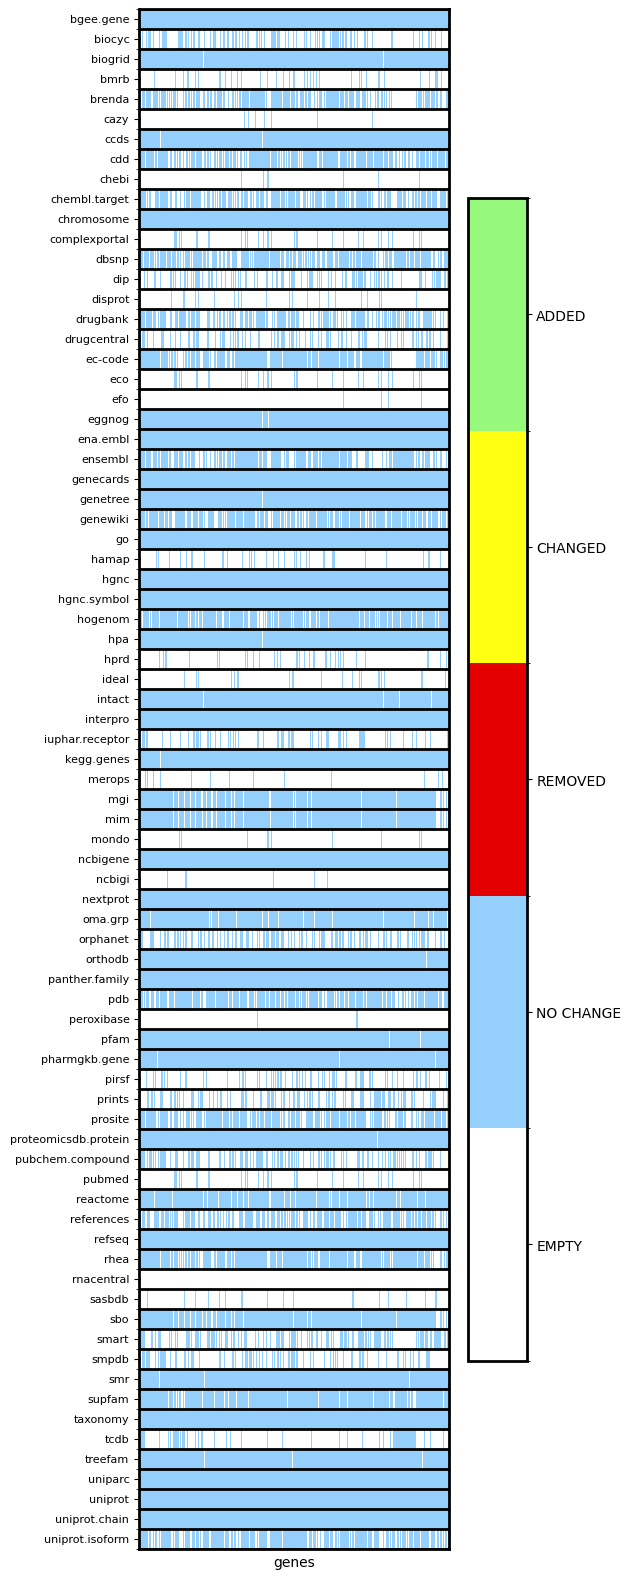

In [13]:
assert (
    len(to_double_check[annotation_type]) == 0
), f"There are still columns with data that need reconcilliation: {to_double_check[annotation_type]}"
df_annotations = model_annotation_dfs[annotation_type]

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=(5, 20))
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{ROOT_PATH}{MODEL_PATH}/{annotation_type}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}.tsv", sep="\t", index=False
    )
df_annotations